# Sediment resuspension parameterization

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import modules.mapping_functions as mf
import cmocean
import pickle
import xarray as xr
import scipy.io

%matplotlib inline

#### Parameters

In [6]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

#### Load files:

In [7]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [8]:
mat         = scipy.io .loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']
ts_mesh     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = ts_mesh['nav_lon'].values
ts_lats     = ts_mesh['nav_lat'].values

#### Calculations

In [10]:
tidal_speed_ANHA12 = mf.interp_np(ts_lons, ts_lats, tidal_speed, mesh_lon, mesh_lat)
tidal_speed_ANHA12[np.isnan(tidal_speed_ANHA12)] = 0
tidal_speed_ANHA12[tidal_speed_ANHA12 < 0.01]    = 0 # mask tidal speeds slower than 1 cm/s

In [12]:
gamma     = 0.065
resus_cst = 1.0e-8

old_erosion_rate     = tidal_speed_ANHA12**2
log_old_erosion_rate = np.log10(old_erosion_rate)

erosion_rate     = gamma*(1-np.exp(-tidal_speed_ANHA12**2/gamma))
log_erosion_rate = np.log10(erosion_rate)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


$ resuspension = 1 - e^{-v^2} \approx 1 - (1 - v^2) = v^2$

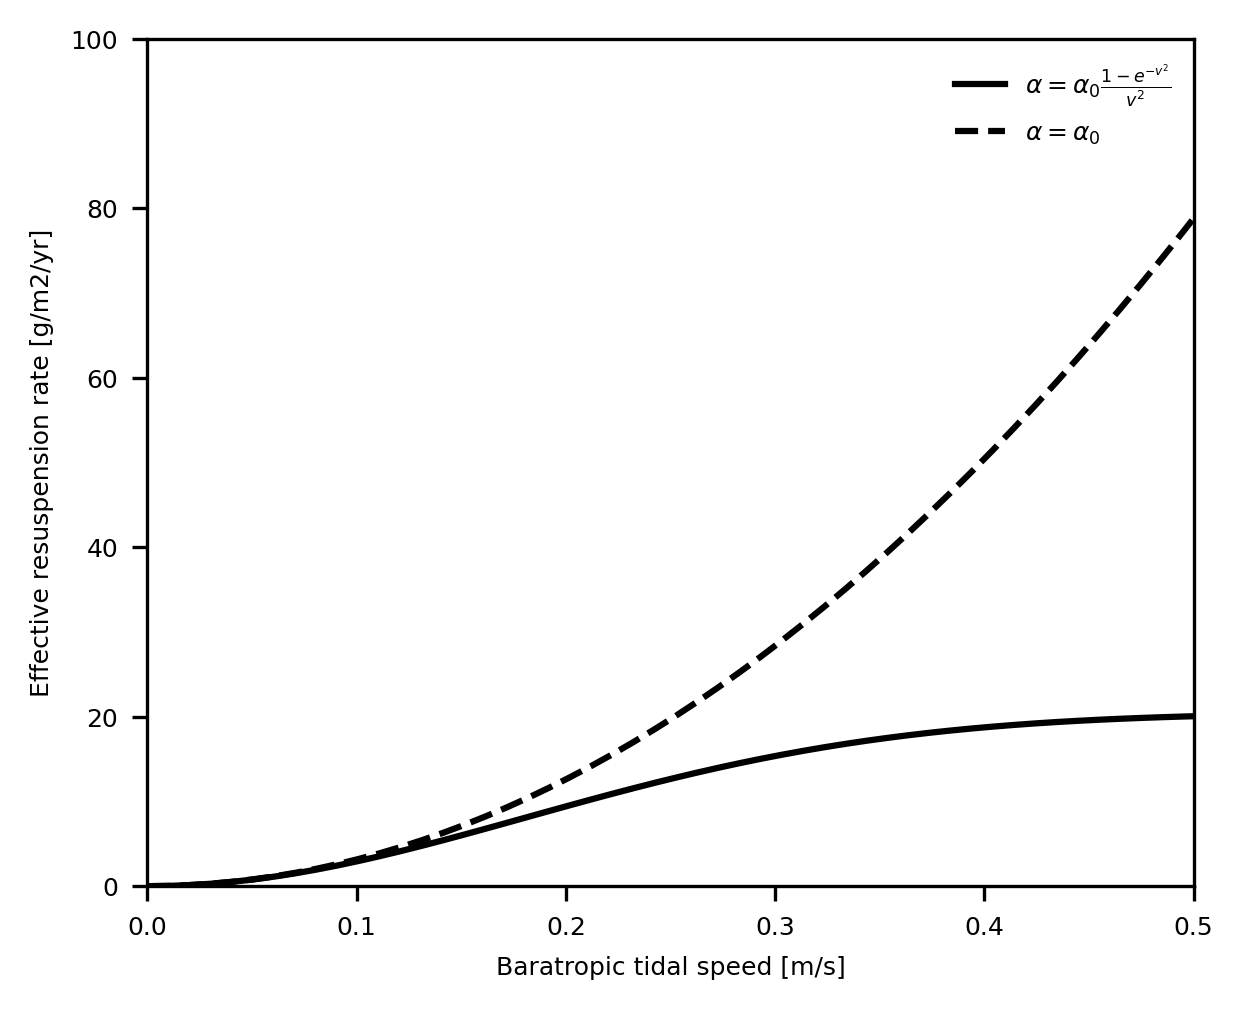

In [17]:
tide           = np.linspace(0,1,100)
# old_solubility_resus_rate      = resus_cst*0.065*(1-np.exp(-(tide)**2/0.065))*3600*24*365*1e3
changing_solubility_resus_rate = resus_cst*gamma*(1-np.exp(-(tide)**2/gamma))*3600*24*365*1e3
constant_solubility_resus_rate = resus_cst*(tide**2)*3600*24*365*1e3

fig, ax = plt.subplots(1,1, figsize=(4.5, 3.74), dpi=300)

ax.plot(tide, changing_solubility_resus_rate, '-k', label=r'$\alpha = \alpha_0\frac{1-e^{-v^2}}{v^2}$')
ax.plot(tide, constant_solubility_resus_rate, '--k', label=r'$\alpha = \alpha_0$')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 100])
ax.set_xlabel('Baratropic tidal speed [m/s]', fontsize=6)
ax.set_ylabel('Effective resuspension rate [g/m2/yr]', fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

ax.legend(fontsize=6, frameon=False)

## Plots

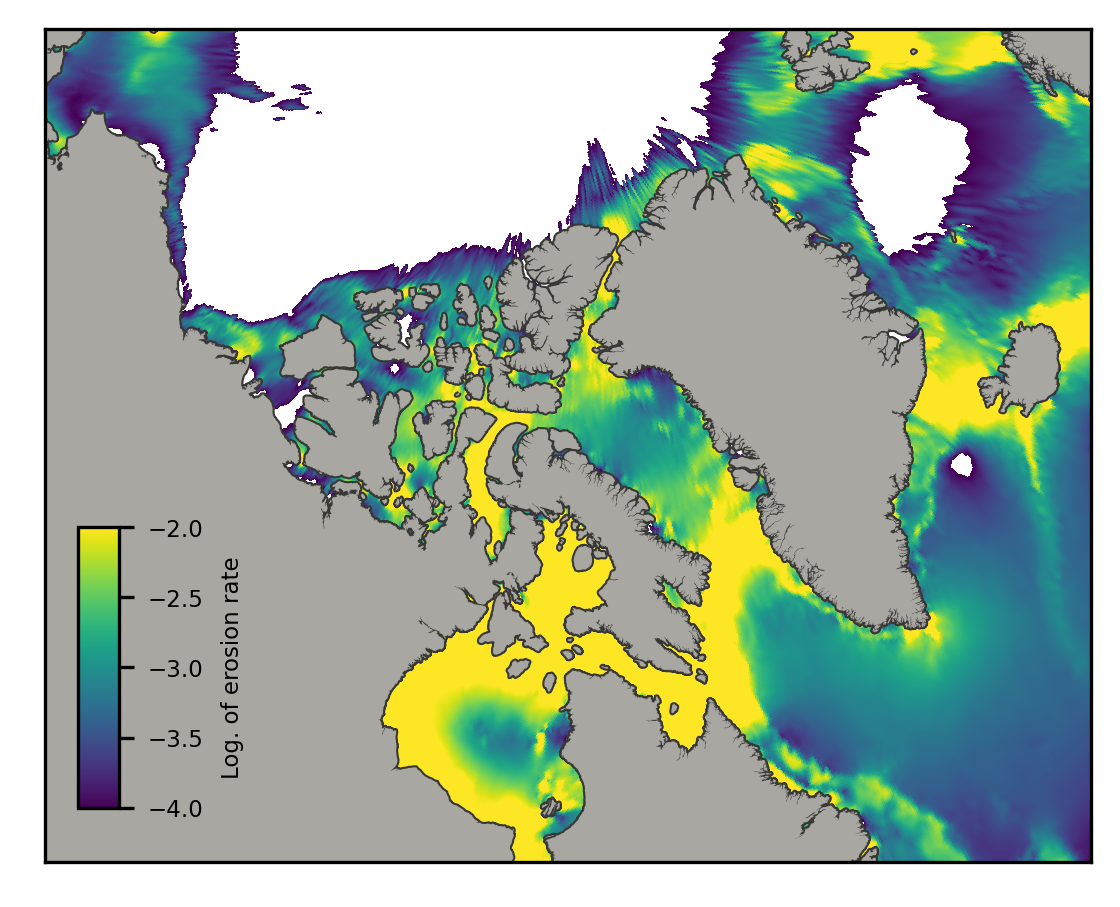

In [18]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-map.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
CB = proj1.pcolormesh(x_sub[:,:], y_sub[:,:], log_erosion_rate[:,:], vmin=-4, vmax=-2)

# proj1.contourf(x_sub, y_sub, bathy_masked[0,:,:], colors=['#d8d8d6']) # land mask

cbaxes = fig.add_axes([0.15, 0.18, 0.03, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes)
CBar.ax.tick_params(labelsize=5.5)
CBar.set_label('Log. of erosion rate', fontsize=5.5)

In [16]:
print('Units [g/m2/yr]')
print(f'Average erosion rate in domain: {resus_cst*np.average(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Median erosion rate in domain:  {resus_cst*np.median(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Maximum erosion rate in domain: {resus_cst*np.amax(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Minimum erosion rate in domain: {resus_cst*np.amin(erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')

print('Units [g/m2/yr]')
print(f'Average erosion rate in domain: {resus_cst*np.average(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Median erosion rate in domain:  {resus_cst*np.median(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Maximum erosion rate in domain: {resus_cst*np.amax(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')
print(f'Minimum erosion rate in domain: {resus_cst*np.amin(old_erosion_rate[imin:imax, jmin:jmax])*1000*365*24*3600:.2f}')

Units [g/m2/yr]
Average erosion rate in domain: 1.73
Median erosion rate in domain:  0.29
Maximum erosion rate in domain: 20.50
Minimum erosion rate in domain: 0.00
Units [g/m2/yr]
Average erosion rate in domain: 3.41
Median erosion rate in domain:  0.29
Maximum erosion rate in domain: 457.65
Minimum erosion rate in domain: 0.00


# Write to file:

In [19]:
file_write = xr.Dataset(
    {'er_rate': (("y","x"), erosion_rate)}, 
    coords = {
        "y": np.zeros(2400),
        "x": np.zeros(1632),
    },
    attrs = {
        'long_name':'Erosion rate',
        'units':'kg/m2/s (when multipled by resus_cst)',
    }
)

file_write.to_netcdf('/ocean/brogalla/GEOTRACES/data/erosion_rate-Pb-20221102.nc')